# *Introduction*

### Problem Definition: Fake News Classification

The goal of the machine learning problem is to train a model that can accurately classify news texts as either "Real" or "Fake" news. Given a news article's text, the model should be able to make a prediction about its authenticity.

**Input** : The input to the model is the text of a news article.

**Output** : The model will output a binary classification label indicating whether the news article is classified as "Real" or "Fake".

**Task** : The task is to build a machine learning model that learns patterns and features from the text data to make accurate predictions about the authenticity of news articles. This involves training the model on a labeled dataset of news articles with their corresponding labels (Real or Fake), and then evaluating the model's performance on unseen test data.

**Approach** : Various machine learning models can be applied to this problem, including logistic regression, naive Bayes, support vector machines (SVM), random forest, gradient boosting, and deep learning models such as recurrent neural networks (RNNs). The choice of model depends on factors such as the dataset size, complexity, available computational resources, and the desired trade-off between model interpretability and predictive performance.

**Evaluation** : The performance of the models can be evaluated using standard evaluation metrics such as accuracy, precision, recall, F1 score, and area under the ROC curve (AUC-ROC). The goal is to build a model that achieves high accuracy and generalizes well to new, unseen news articles.

The process involves steps such as data preprocessing (cleaning, tokenization, removing stop words, etc.), feature engineering (TF-IDF, word embedding), model selection and training, hyperparameter tuning, and evaluation on a separate test set.

The end goal is to develop a robust and accurate model that can effectively differentiate between real and fake news articles, helping users make informed judgments about the credibility of the information they encounter.

In [184]:
# Importing the required packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
import pickle

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# download stopwords
nltk.download("stopwords")

import gensim
from gensim import corpora
from gensim.models import LdaModel

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\email\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
# Read the CSV file
data_path = 'data/news/train_processed.csv'
news_df = pd.read_csv(data_path, encoding='UTF-8')

# Split the data into train, validation, and test sets
train_df, temp_df = train_test_split(news_df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Print the shape of the dataframes
print("Train Data Shape:", train_df.shape)
print("Validation Data Shape:", val_df.shape)
print("Test Data Shape:", test_df.shape)

Train Data Shape: (16606, 6)
Validation Data Shape: (2076, 6)
Test Data Shape: (2076, 6)


In [15]:
train_df.head(5)

,title,text,label,news,clean,clean_joined
8238,California Prepares for Long-Denied Star Turn ...,"BURLINGAME, Calif. — This is the most popul...",0,California Prepares for Long-Denied Star Turn ...,"['california', 'prepares', 'long', 'denied', '...",california prepares long denied star turn pres...
11526,"Larry Colburn, Who Helped Stop My Lai Massacre...","Larry Colburn, who became an American hero ...",0,"Larry Colburn, Who Helped Stop My Lai Massacre...","['larry', 'colburn', 'helped', 'stop', 'massac...",larry colburn helped stop massacre dies york t...
9982,A Tear in the Fabric of America’s Political Th...,[Graphic: Clinton vs Trump by DonkeyHotey .] P...,1,A Tear in the Fabric of America’s Political Th...,"['tear', 'fabric', 'america', 'political', 'th...",tear fabric america political theater graphic ...
11282,Chart Of The Day: The Bond Vigilantes Are Back...,Chart Of The Day: The Bond Vigilantes Are Back...,1,Chart Of The Day: The Bond Vigilantes Are Back...,"['chart', 'bond', 'vigilantes', 'yield', 'elec...",chart bond vigilantes yield election chart bon...
17713,Turkish Parliament Approves Stripping Lawmaker...,ISTANBUL — Lawmakers from President Recep T...,0,Turkish Parliament Approves Stripping Lawmaker...,"['turkish', 'parliament', 'approves', 'strippi...",turkish parliament approves stripping lawmaker...


In [25]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16606 entries, 9958 to 15795
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         16155 non-null  object
 1   text          16606 non-null  object
 2   label         16606 non-null  int64 
 3   news          16606 non-null  object
 4   clean         16606 non-null  object
 5   clean_joined  16606 non-null  object
dtypes: int64(1), object(5)
memory usage: 908.1+ KB


Splitting the data into train, validation, and test sets, ensuring that the data is representative of the overall dataset. This helps us assess the performance of the model on unseen data.

In [99]:
# Split the data into train, validation, and test sets
X_trainval, X_test, y_trainval, y_test = train_test_split(news_df['clean_joined'], news_df['label'], test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)  # 60% train, 20% validation

Applying TF-IDF vectorization to convert the text data into numerical features that can be used by the Logistic Regression model. TF-IDF helps in giving higher weightage to words that are more informative for classification.

In [119]:
# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_tfidf = vectorizer.fit_transform(X_train)

In [117]:
# Transform the validation data
X_val_tfidf = vectorizer.transform(X_val)

### Logistic Regression

To find the best hyperparameters for the Logistic Regression model, we are utilizing a pipeline in combination with a grid search. The pipeline allows us to streamline the workflow by chaining the data preprocessing steps and the model fitting. The grid searches systematically and explore different combinations of hyperparameters and select the ones that yield the best performance.

In [ ]:
# Create a logistic regression model
logreg = LogisticRegression()

# Define the hyperparameters to tune
param_grid = {
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logreg__penalty': ['l1', 'l2']
}

# Create the pipeline
pipeline = Pipeline([('tfidf', vectorizer), ('logreg', logreg)])

# Perform grid search to find the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_trainval, y_trainval)

# Get the best parameters
best_params = grid_search.best_params_

In [41]:
best_params

{'logreg__C': 100, 'logreg__penalty': 'l2'}

In [38]:
# Train the model with the best parameters
logreg = LogisticRegression(C=best_params['logreg__C'], penalty=best_params['logreg__penalty'])
logreg.fit(X_train_tfidf, y_train)

# Make predictions on the validation data
y_pred_val = logreg.predict(X_val_tfidf)

In [115]:
# Make predictions on the train data
y_pred_train = logreg.predict(X_train_tfidf)

# Calculate evaluation metrics for train data
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train)
f1_train = f1_score(y_train, y_pred_train)

# Print the evaluation metrics for train data
print("Train Accuracy:", accuracy_train)
print("Train Precision:", precision_train)
print("Train Recall:", recall_train)
print("Train F1-score:", f1_train)

Train Accuracy: 1.0
Train Precision: 1.0
Train Recall: 1.0
Train F1-score: 1.0


In [39]:
# Calculate evaluation metrics for validation data
accuracy_val = accuracy_score(y_val, y_pred_val)
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1_val = f1_score(y_val, y_pred_val)

# Print the evaluation metrics for validation data
print("Validation Accuracy:", accuracy_val)
print("Validation Precision:", precision_val)
print("Validation Recall:", recall_val)
print("Validation F1-score:", f1_val)

Validation Accuracy: 0.9593256622959593
Validation Precision: 0.9595628415300547
Validation Recall: 0.9574700109051254
Validation F1-score: 0.9585152838427947


In [120]:
# Calculate predictions on the test data
X_test_tfidf = vectorizer.transform(X_test)
y_pred_test = logreg.predict(X_test_tfidf)

In [121]:
# Calculate test accuracy
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print("Test Accuracy:", accuracy_test)
print("Test Precision:", precision_val)
print("Test Recall:", recall_val)
print("Test F1-score:", f1_val)

# Change the threshold for better recall
y_pred_proba_val = logreg.predict_proba(X_val_tfidf)[:, 1]  # Predicted probabilities for positive class
threshold = 0.5  # Original threshold
y_pred_threshold = (y_pred_proba_val > threshold).astype(int)
recall_threshold = recall_score(y_val, y_pred_threshold)
print("Validation Recall (Threshold = 0.5):", recall_threshold)

# Change the threshold to improve recall
threshold = 0.3  # New threshold
y_pred_threshold = (y_pred_proba_val > threshold).astype(int)
recall_threshold = recall_score(y_val, y_pred_threshold)
print("Validation Recall (Threshold = 0.3):", recall_threshold)

Test Accuracy: 0.9605009633911368
Test Precision: 0.9595628415300547
Test Recall: 0.9574700109051254
Test F1-score: 0.9585152838427947
Validation Recall (Threshold = 0.5): 0.9574700109051254
Validation Recall (Threshold = 0.3): 0.9749182115594329


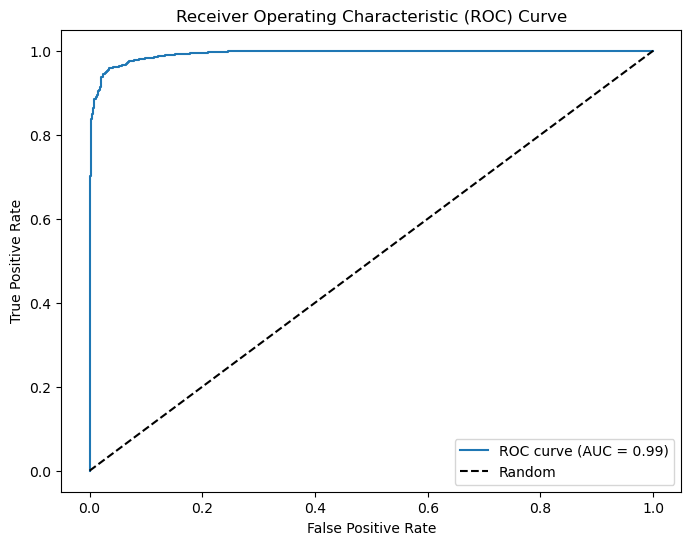

In [59]:
y_pred_proba_test = logreg.predict_proba(X_test_tfidf)[:, 1]
# Compute false positive rate (FPR) and true positive rate (TPR)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test)

# Calculate AUC score
auc_score = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [62]:
with open('logreg_model.pkl', 'wb') as file:
    pickle.dump(logreg, file)

### Naive Bayes 

We are exploring the performance of two Naive Bayes variants: Multinomial Naive Bayes and Bernoulli Naive Bayes. Multinomial Naive Bayes is suitable for discrete features such as word counts, while Bernoulli Naive Bayes is suitable for binary features such as presence or absence of words.

We are using a pipeline in combination with a grid search to find the best hyperparameters for the Naive Bayes models. The pipeline allows us to preprocess the data using TF-IDF vectorization and then apply the Naive Bayes model. The grid search helps us systematically explore different combinations of hyperparameters to find the ones that yield the best performance.

By evaluating the models using different evaluation metrics, such as accuracy and ROC curve, we can assess their classification performance and choose the best model for our task.

In [101]:
# Define and train the Naive Bayes model
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_tfidf, y_train)

MultinomialNB()

In [102]:
# Make predictions on the validation data
y_pred_val = naive_bayes.predict(X_val_tfidf)

In [103]:
# Evaluate the model on the validation data
accuracy = accuracy_score(y_val, y_pred_val)
precision = precision_score(y_val, y_pred_val)
recall = recall_score(y_val, y_pred_val)
f1 = f1_score(y_val, y_pred_val)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy: 0.8643296762108643
Precision: 0.9797541576283442
Recall: 0.7388222464558343
F1-Score: 0.8423997513211066


In [104]:
# Make predictions on the test data
y_pred_test = naive_bayes.predict(X_test_tfidf)

# Evaluate the model on the test data
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)

# Print the evaluation metrics for the test data
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1-Score:", test_f1)

Test Accuracy: 0.8535645472061657
Test Precision: 0.9865591397849462
Test Recall: 0.7140077821011673
Test F1-Score: 0.8284424379232506


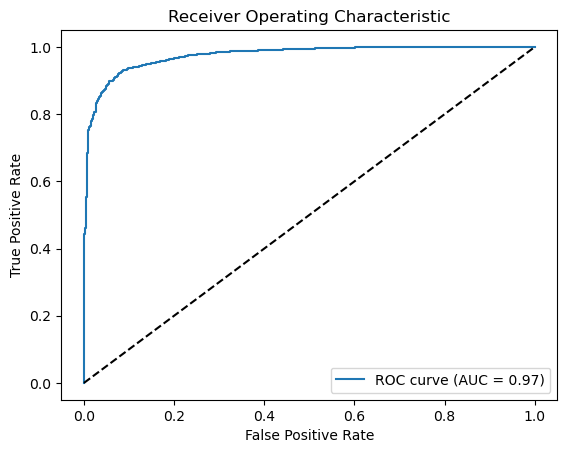

In [105]:
# Get predicted probabilities for positive class
y_pred_proba = naive_bayes.predict_proba(X_test_tfidf)[:, 1]

# Compute the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [114]:
# Save the Naive Bayes model

with open('naivebayes_model.pkl', 'wb') as file:
    pickle.dump(naive_bayes, file)

### Random Forest
Here we will focus on tuning hyperparameter for the Random Forest (RF) model: the number of estimators (or the number of decision trees in the forest). The number of estimators in a Random Forest model can significantly impact the model's ability to capture complex patterns in the data.

A Random Forest model works by creating multiple decision trees (estimators) and combining their predictions. The number of these decision trees is a parameter that needs to be tuned. Too few trees might lead to a model that is too simple and cannot capture all the information in the data (underfitting), while too many trees could make the model too complex and could lead to overfitting, where the model starts learning from the noise in the data.

We approach the tuning of the number of estimators in the Random Forest model using a simple iterative process. We begin with a low number of trees and gradually increase this number. For each value, we train a Random Forest model and record its accuracy on both the training and validation data.

The number of trees is incremented from 5 to 100 in steps of 5. For each step, the model's performance on the training and validation sets is recorded. This allows us to see how the model's performance changes as the number of estimators increases.

In [123]:
train_scores = []
val_scores = []


n_range = range(5,101,5)

for n in n_range:
    
    # Instantiate the model
    RF_model = RandomForestClassifier(n_estimators=n)
    
    # Fit
    RF_model.fit(X_train_tfidf, y_train)
    
    # Scores
    train_acc = RF_model.score(X_train_tfidf, y_train)
    val_acc = RF_model.score(X_val_tfidf, y_val)
    
    train_scores.append(train_acc)
    val_scores.append(val_acc)

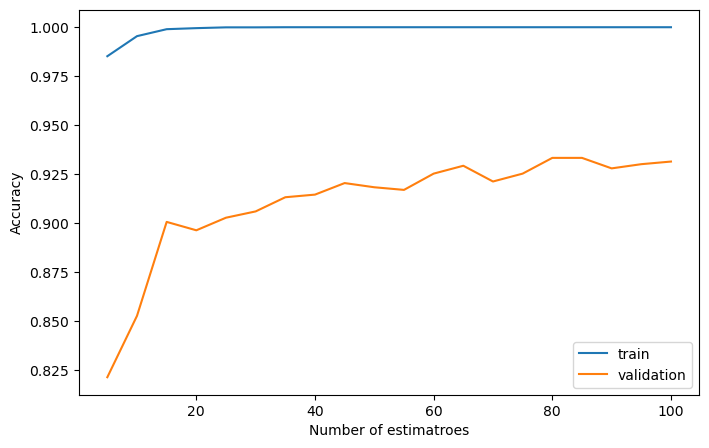

In [125]:
plt.figure(figsize=(8,5))

plt.plot(n_range, train_scores, label = 'train')
plt.plot(n_range, val_scores, label = 'validation')

plt.xlabel('Number of estimatroes')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

In [138]:
best_estimator = val_scores.index(max(val_scores)) * 5

best_estimator

75

We found that as the number of estimators increased, so did the performance of the model on both the training and validation data, up to a certain point. However, beyond around 75 estimators, we observed that the validation accuracy remained relatively stable, suggesting that adding more estimators beyond this point does not significantly improve the model's generalization performance on unseen data. Therefore, in the context of our study and for this specific dataset, a Random Forest model with around 75 estimators provides an optimal balance between training performance and validation performance. It's a valuable insight that helps to avoid unnecessary computational cost without compromising the model's ability to generalize well to unseen data.

In [ ]:
# Instantiate the model
RF_model = RandomForestClassifier(n_estimators=75)

# Fit
RF_model.fit(X_train_tfidf, y_train)

# Scores
train_acc = RF_model.score(X_train_tfidf, y_train)
val_acc = RF_model.score(X_val_tfidf, y_val)
test_acc = RF_model.score(X_test_tfidf, y_test)

In [140]:
# Print the evaluation metrics 
print("Validation Accuracy:", val_acc)
print("Test Accuracy:", test_acc)

Validation Accuracy: 0.9355097671929355
Test Accuracy: 0.9368978805394991


The test accuracy is found to be 93.68% which is good. However, logistic regression still remains the model with best accuracy.

### Feature Importance

In this section, we delve into interpreting our best model so far. Logistic regression was found to be the best model so far with 96% accuracy. It would be great to understand what are the most important words that is positively and negatively contributing to the accuracy.

In the below code we will start by using the feature_importances_ property of the Random Forest and sort the word based on the importance score.


In [207]:
importances = list(RF_model.feature_importances_)

In [148]:
feature_names = vectorizer.get_feature_names()

# Now you can access the column names
print(feature_names[:10])  # Print the first 10 feature names

['a_s_sinated', 'aaaaggg', 'aaah', 'aaahhh', 'aaajiao', 'aaany', 'aaas', 'aabb', 'aabenraa', 'aachen']


In [159]:
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_names, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
feature_importances[0:20]

[('breitbart', 0.02),
 ('times', 0.02),
 ('york', 0.02),
 ('follow', 0.01),
 ('hillary', 0.01),
 ('president', 0.01),
 ('said', 0.01),
 ('twitter', 0.01),
 ('a_s_sinated', 0.0),
 ('aaaaggg', 0.0),
 ('aaah', 0.0),
 ('aaahhh', 0.0),
 ('aaajiao', 0.0),
 ('aaany', 0.0),
 ('aaas', 0.0),
 ('aabb', 0.0),
 ('aabenraa', 0.0),
 ('aachen', 0.0),
 ('aadara', 0.0),
 ('aadmi', 0.0)]

In the code below we will try to visualize the coefficients of a logistic regression model, thereby providing a measure of the importance of each feature used by the model in predicting the target variable. This code specifically targets the features with the highest coefficients (both positive and negative) in terms of their absolute value, indicating the most significant features(words) in the model.

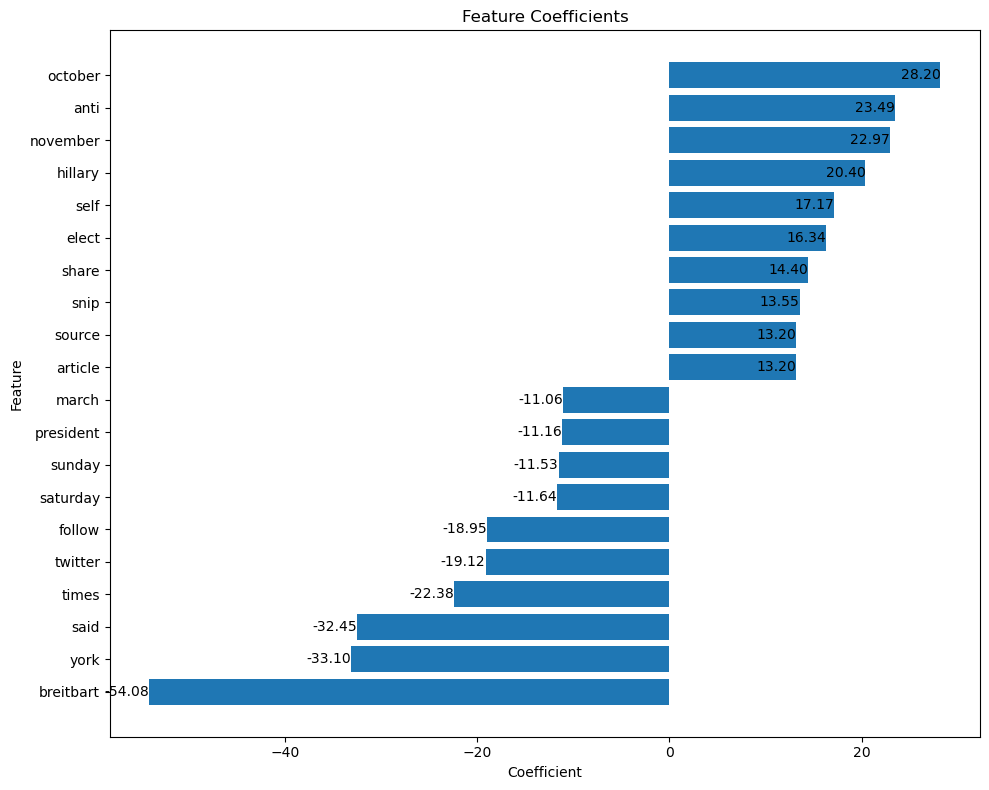

In [178]:
# Get the coefficients from the logistic regression model
coefficients = logreg.coef_[0]

# Get the feature names from the TfidfVectorizer
feature_names = vectorizer.get_feature_names()

# Create a DataFrame to store the coefficients and corresponding feature names
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the DataFrame by the absolute value of the coefficients in descending order
coefficients_df['Absolute Coefficient'] = coefficients_df['Coefficient'].abs()
coefficients_df = coefficients_df.sort_values(by='Absolute Coefficient', ascending=False)

# Display the top N most important features
N = 20
top_features = coefficients_df.head(N)
#print(top_features)

coefficients_sorted = top_features.sort_values('Coefficient')

# Plot the horizontal bar plot
plt.figure(figsize=(10, 8))
plt.barh(coefficients_sorted['Feature'], coefficients_sorted['Coefficient'])
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Feature Coefficients')
# Annotate the bars with their corresponding coefficient values
for index, value in enumerate(coefficients_sorted['Coefficient']):
    plt.text(value, index, f'{value:.2f}', ha='right', va='center')
plt.tight_layout()
plt.show()


Finally, lets save the Naive Bayes model to a pickle file.

In [ ]:
# Save the Niave Bayes model
with open('randomforest_model.pkl', 'wb') as file:
    pickle.dump(RF_model, file)

### Testing the logistic regression model

In the following section, we will test the logistic regression model by passing test news articles created with the help of Bing chat. The Fake news from different topics were generated and assigned to variables fakenews_test, fakenews_test1, fakenews_test2, fakenews_test3. Functions preprocess and fake_news_detector was created to test the news authenticity.

In [198]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Function removes the stop words and remove words with 2 or less characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text, max_len=25):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)

    return [' '.join(result)]

In [216]:
# Function to vectorize the preprocessed news article and uses the logreg model to predict the \
# authenticity of the news article.
def fake_news_detector(topic, news_type, news_article):
    # Transform the single document (string) using the pre-fitted vectorizer
    fakenews_test_tfidf = vectorizer.transform(preprocess(news_article))

    # fakenews_test_tfidf will be a sparse matrix representing the TF-IDF representation of the input document

    # Predict the class (fake or real) using the logistic regression model
    prediction = logreg.predict(fakenews_test_tfidf)
    # Print the prediction
    print(f"Test of \"{news_type}\" news on \"{topic}\" topic was predicted to be :", "Real" if prediction == 0 else "Fake")

In [ ]:
fakenews_test = '''BREAKING: President Biden Resigns After Secret Deal With China Exposed. 
In a shocking turn of events, President Joe Biden announced his resignation today after a whistleblower revealed that he had made a secret deal with China to sell US military secrets and technology in exchange for personal favors and financial benefits. The whistleblower, who claims to be a former aide of Biden, leaked a series of emails and documents that allegedly prove the existence of the deal, which was signed by Biden and Chinese President Xi Jinping in January 2021.
According to the whistleblower, the deal involved Biden agreeing to provide China with access to classified information on US weapons systems, cyberwarfare capabilities, and intelligence operations, as well as lifting sanctions and tariffs on Chinese goods and companies. In return, Biden would receive a large sum of money deposited in an offshore account, as well as political support from China for his domestic and foreign agenda.
The whistleblower also claimed that Biden had used his influence to silence any opposition or criticism of the deal, and that he had threatened to fire or prosecute anyone who tried to expose it. The whistleblower said that he decided to come forward after he realized the grave danger that the deal posed to US national security and democracy.
Biden’s resignation comes amid widespread outrage and protests from both Democrats and Republicans, who have called for his impeachment and criminal investigation. Vice President Kamala Harris has assumed the role of acting president, and has vowed to cooperate with any inquiry into the matter. She has also expressed her shock and disappointment at Biden’s actions, and said that she was unaware of the deal until today.
China has denied any involvement in the deal, and has accused the whistleblower of fabricating evidence and spreading lies. A spokesperson for the Chinese Foreign Ministry said that the allegations were part of a “malicious smear campaign” orchestrated by anti-China forces in the US, and that China had always respected US sovereignty and interests.'''

In [197]:
fakenews_test2 = '''EXCLUSIVE: Oprah Winfrey Reveals She Has a Secret Daughter
In a shocking revelation, Oprah Winfrey has admitted that she has a secret daughter that she gave up for adoption when she was 17 years old. The media mogul made the confession in an emotional interview with her best friend Gayle King, which will air on CBS next week.
According to Oprah, she became pregnant as a teenager after being sexually abused by a relative, and decided to give up her baby girl for adoption because she felt she was not ready to be a mother. She said that she never forgot about her daughter, and always wondered what happened to her.
Oprah said that she recently received a letter from a woman named Lisa, who claimed to be her biological daughter. Lisa said that she had been searching for her birth mother for years, and had finally found her through a DNA test. She said that she wanted to meet Oprah and establish a relationship with her.
Oprah said that she was shocked and skeptical at first, but agreed to meet Lisa in a private location. She said that when she saw Lisa, she immediately recognized her as her daughter, because they had the same eyes and smile. She said that they hugged and cried, and started to get to know each other.
Oprah said that she was sorry for giving up Lisa, and that she hoped to make up for the lost time. She said that she wanted to introduce Lisa to her family and friends, and to the world. She said that Lisa was her miracle, and that she loved her very much.'''

In [203]:
fakenews_test3 = '''BREAKING: China Declares War on India over Border Dispute

In a shocking and unprecedented move, China has officially declared war on India over the long-standing border dispute in the Himalayan region. The announcement was made by Chinese President Xi Jinping in a televised address to the nation, in which he accused India of violating China’s sovereignty and territorial integrity, and threatened to use all means necessary to defend China’s interests.

According to Xi, China has tried to resolve the border issue peacefully and diplomatically, but India has repeatedly provoked and attacked Chinese troops and civilians along the Line of Actual Control (LAC), the de facto border between the two countries. He said that India’s actions have seriously endangered regional peace and stability, and posed a grave threat to China’s national security.

Xi said that China has no choice but to take decisive military action to safeguard its national dignity and honor, and to protect its people from Indian aggression. He said that China will not tolerate any infringement on its core interests, and will not allow any foreign power to interfere in its internal affairs. He said that China is ready to fight a just war against India, and to win a glorious victory.

Xi also called on the Chinese people to unite behind the Communist Party and the People’s Liberation Army, and to support the war effort with patriotism and courage. He said that China is a strong and resilient nation, and that no enemy can defeat it. He said that China will always uphold its sovereignty, security and development interests, and will always pursue peace and cooperation with other countries.

The declaration of war by China has sent shockwaves across the world, and has triggered a global crisis. The United Nations Security Council has convened an emergency meeting to discuss the situation, and has urged both sides to exercise restraint and de-escalate tensions. The United States, Russia, Japan, Australia and other countries have also expressed their grave concern over the outbreak of war, and have called for dialogue and diplomacy to resolve the dispute.

India has not yet issued an official response to China’s declaration of war, but sources say that Prime Minister Narendra Modi is holding an urgent cabinet meeting to discuss the situation. India has also reportedly mobilized its troops and weapons along the LAC, and has put its air force and navy on high alert. India has also sought support from its allies and partners, especially the US, which has a strategic partnership with India.

The border dispute between China and India dates back to the colonial era, when Britain drew an arbitrary boundary between Tibet and India, known as the McMahon Line. China does not recognize this line, and claims about 90,000 square kilometers of Indian territory in Arunachal Pradesh as part of southern Tibet. India also claims about 38,000 square kilometers of Chinese territory in Aksai Chin as part of Ladakh. The two countries fought a brief but bloody war over the border in 1962, which resulted in a Chinese victory. Since then, the two sides have had several skirmishes and standoffs along the LAC, but have never resorted to full-scale war.

The current crisis was sparked by a violent clash between Chinese and Indian troops in the Galwan Valley in June 2020, which resulted in the deaths of 20 Indian soldiers and an unknown number of Chinese casualties. The two sides agreed to disengage and de-escalate after several rounds of talks, but tensions remained high as both sides continued to build up their forces along the LAC. The situation worsened in October 2020, when China accused India of firing shots at its troops near Pangong Lake, which India denied. Since then, both sides have accused each other of violating agreements and crossing into each other’s territory.

The war between China and India could have devastating consequences for both countries and the world. Both countries are nuclear-armed powers with large populations and economies. A prolonged war could result in massive casualties, displacement, environmental damage, economic disruption, social unrest and humanitarian crisis. It could also destabilize the region and trigger a wider conflict involving other countries. It is hoped that both sides will find a peaceful solution to their dispute before it is too late.'''

In [204]:
fakenews_test4 = '''Tom Cruise Announces Retirement from Acting

In a shocking and unexpected move, Tom Cruise has announced that he is retiring from acting after nearly four decades in the industry. The Hollywood superstar made the announcement in an exclusive interview with Variety, in which he said that he wanted to focus on his personal life and other interests.

According to Cruise, he has been feeling burned out and disillusioned with the movie business, and has decided to call it quits after completing his upcoming projects. He said that he has achieved everything he wanted to achieve as an actor, and that he has nothing left to prove. He said that he is grateful for all the opportunities and experiences he has had, and for all the fans and colleagues who have supported him throughout his career.

Cruise said that he plans to spend more time with his family and friends, and to pursue his hobbies and passions, such as flying, sailing and philanthropy. He said that he also wants to explore his spirituality and faith, and to devote more time to his involvement with the Church of Scientology. He said that he is looking forward to a new chapter in his life, and that he is happy and at peace with his decision.

Cruise’s retirement announcement has stunned and saddened his fans and peers, who have expressed their admiration and appreciation for his work and legacy. Cruise is widely regarded as one of the most successful and influential actors of all time, having starred in over 40 films, many of which are considered classics and blockbusters. He is best known for his roles in films such as Top Gun, Rain Man, A Few Good Men, Jerry Maguire, Mission: Impossible, Minority Report, The Last Samurai, War of the Worlds, Tropic Thunder, Edge of Tomorrow, American Made and Jack Reacher. He has been nominated for three Academy Awards and seven Golden Globes, winning three of them. He has also received numerous other awards and honors, including the AFI Life Achievement Award, the BAFTA Stanley Kubrick Britannia Award for Excellence in Film, and the Kennedy Center Honors.

Cruise’s retirement announcement comes as a surprise, as he has been busy working on several projects in recent years. He is currently filming Mission: Impossible 8, the eighth installment of the popular spy franchise that he has been leading since 1996. He is also set to star in Top Gun: Maverick, the sequel to his 1986 breakthrough film Top Gun, which is scheduled for release in May 2023. He is also attached to star in two other films: Luna Park, a sci-fi adventure directed by Doug Liman, and Live Die Repeat and Repeat, the sequel to his 2014 hit Edge of Tomorrow.

Cruise said that he will honor his commitments to these projects, but that they will be his last as an actor. He said that he hopes that his fans will enjoy his final performances, and that they will respect his choice to retire. He said that he will always love acting, but that he feels that it is time for him to move on.'''

In [220]:
fake_news_detector("Politics", "Fake", fakenews_test)
fake_news_detector("Other", "Fake", fakenews_test2)
fake_news_detector("Politics", "Fake", fakenews_test3)
fake_news_detector("Media and Entertainment", "Fake", fakenews_test4)

Test of "Fake" news on "Politics" topic was predicted to be : Fake
Test of "Fake" news on "Other" topic was predicted to be : Real
Test of "Fake" news on "Politics" topic was predicted to be : Fake
Test of "Fake" news on "Media and Entertainment" topic was predicted to be : Real


### Testing conclusion

Testing seems to have good accuracy on political news topics but performs badly on news topics that are non political. This shows that the model is biased towards political news and is not great option for predicting any type of news.